In [1]:
# Mount my Drive to access the uploaded cam frames and sensor data CSV

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1: Combining the CSV and Images to reduce future load

```
VERBOSE SENSOR DATA EXAMPLE REFERENCE:

--------------------------------
Receive Data from F1TENTH: V1
--------------------------------

Throttle: 0.0
Steering: 0.0
Encoder Ticks:  0 0
Encoder Angles: 0.0 0.0
Position: 0.741 3.158 0.059
Orientation [Quaternion]: 0.011 0.011 -0.707 0.707
Orientation [Euler Angles]: 0.0 0.031 4.712
Angular Velocity: 0.0 0.0 0.0
Linear Acceleration: 0.0 0.0 0.004
LIDAR Scan Rate: 20.0
LIDAR Range Array:
[0.7476186 0.7444674 0.7413569 ... 1.152192  1.158022  1.162451 ]
LIDAR Intensity Array:
[47. 47. 47. ... 47. 47. 47.]
```

In [2]:
# IMPORTS

import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import bz2
import cv2
import pickle
import h5py
from multiprocessing import Pool, cpu_count

In [ ]:
# Loading the data from Drive
f110_logs = pd.read_csv("/content/drive/MyDrive/Dissertation/recorded_data_new.csv")

In [4]:
num_columns = f110_logs.shape
print(f"Number of columns: {num_columns[1]}")
print(num_columns)
f110_logs.head()

Number of columns: 26
(5413, 26)


,timestamp,throttle,steering,encoder_ticks_left,encoder_ticks_right,encoder_angles_left,encoder_angles_right,position_x,position_y,position_z,...,orientation_euler_yaw,angular_velocity_x,angular_velocity_y,angular_velocity_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,lidar_scan_rate,lidar_ranges,camera_frame
0,2024-06-26 17:13:51.854077,0.285,0.032,1452,1450,4.752,4.745,0.741,3.045,0.057,...,4.724,0.004,-0.076,0.111,7.665,0.094,0.019,20.0,"[0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...",recorded_frames_new/0.jpg
1,2024-06-26 17:13:51.953301,0.286,0.031,2162,2166,7.075,7.088,0.743,2.914,0.057,...,4.736,-0.002,0.053,0.126,0.691,-0.031,0.082,20.0,"[0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...",recorded_frames_new/1.jpg
2,2024-06-26 17:13:52.056838,0.287,0.027,2911,2920,9.526,9.556,0.748,2.771,0.057,...,4.749,-0.007,0.042,0.112,0.222,-0.068,0.065,20.0,"[0.7515233, 0.7485677, 0.7456495, 0.742768, 0....",recorded_frames_new/2.jpg
3,2024-06-26 17:13:52.162178,0.289,0.023,3717,3731,12.164,12.210,0.754,2.616,0.058,...,4.761,-0.004,0.024,0.096,0.168,-0.025,0.037,20.0,"[0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...",recorded_frames_new/3.jpg
4,2024-06-26 17:13:52.269002,0.291,0.019,4537,4555,14.847,14.906,0.763,2.458,0.058,...,4.772,-0.007,0.014,0.081,0.180,-0.053,0.028,20.0,"[0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...",recorded_frames_new/4.jpg


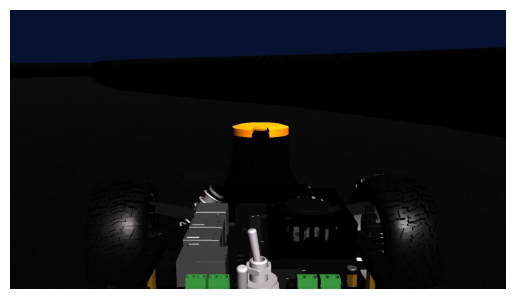

Image: 2387.jpg


In [5]:
images_dir = "/content/drive/MyDrive/Dissertation/recorded_frames_new"
image_files = os.listdir(images_dir)

random_image = random.choice(image_files)
img_path = os.path.join(images_dir, random_image)
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"Image: {random_image}")

### Preprocessing Stuff

Resize all images first


In [6]:
def process_image(image_path, target_size=(320, 180)):
    try:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size).astype(np.float32)  # set the image to my dims
        else:
            image = np.zeros((*target_size, 3), dtype=np.float32)  # pad zeroes if img not found strat
        return image
    except Exception as e:
        return np.zeros((*target_size, 3), dtype=np.float32)

def process_chunk(image_paths, target_size, num_workers):  # process chunks of the set with max cpu workers
    with Pool(num_workers) as pool:
        image_arrays = pool.starmap(process_image, [(path, target_size) for path in image_paths])
    return image_arrays

def save_chunk_to_hdf5(image_arrays, hdf5_file_path, chunk_index):  # best compressed format?
    with h5py.File(hdf5_file_path, 'a') as h5f:
        if chunk_index == 0:
            maxshape = (None,) + image_arrays[0].shape
            dset = h5f.create_dataset('image_arrays', data=image_arrays, maxshape=maxshape, compression='gzip', compression_opts=9)
        else:
            dset = h5f['image_arrays']
            dset.resize(dset.shape[0] + len(image_arrays), axis=0)
            dset[-len(image_arrays):] = image_arrays

def process_and_save_in_chunks(df, images_dir, hdf5_file_path, target_size=(320, 180), chunk_size=100):
    num_workers = cpu_count()  # max cpu cores
    print(f"Using {num_workers} CPU cores for image processing.")

    image_paths = [os.path.join(images_dir, os.path.basename(image_name)) for image_name in df['camera_frame']]  # nav to the right dir
    num_chunks = len(image_paths) // chunk_size + int(len(image_paths) % chunk_size > 0)

    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(image_paths))
        chunk = image_paths[start:end]

        print(f"Processing chunk {i+1}/{num_chunks} with {len(chunk)} images.")
        image_arrays = process_chunk(chunk, target_size, num_workers)

        save_chunk_to_hdf5(image_arrays, hdf5_file_path, i)  # save with indices for retreival

        print(f"Processed and saved chunk {i+1}/{num_chunks}")

In [8]:
images_dir = "/content/drive/MyDrive/Dissertation/recorded_frames_new"
hdf5_file_path = "/content/drive/MyDrive/Dissertation/img_arrays_smol.h5"


process_and_save_in_chunks(f110_logs, images_dir, hdf5_file_path, chunk_size=100)

Using 8 CPU cores for image processing.
Processing chunk 1/55 with 100 images.
Processed and saved chunk 1/55
Processing chunk 2/55 with 100 images.
Processed and saved chunk 2/55
Processing chunk 3/55 with 100 images.
Processed and saved chunk 3/55
Processing chunk 4/55 with 100 images.
Processed and saved chunk 4/55
Processing chunk 5/55 with 100 images.
Processed and saved chunk 5/55
Processing chunk 6/55 with 100 images.
Processed and saved chunk 6/55
Processing chunk 7/55 with 100 images.
Processed and saved chunk 7/55
Processing chunk 8/55 with 100 images.
Processed and saved chunk 8/55
Processing chunk 9/55 with 100 images.
Processed and saved chunk 9/55
Processing chunk 10/55 with 100 images.
Processed and saved chunk 10/55
Processing chunk 11/55 with 100 images.
Processed and saved chunk 11/55
Processing chunk 12/55 with 100 images.
Processed and saved chunk 12/55
Processing chunk 13/55 with 100 images.
Processed and saved chunk 13/55
Processing chunk 14/55 with 100 images.
Pr

# 2: Loading the combined data for use

In [9]:
# Mount my Drive to access the uploaded cam frames and sensor data CSV

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# IMPORTS

import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import bz2
import cv2
import pickle
import h5py
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split

In [11]:
def load_images_from_hdf5(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as h5f:
        image_arrays = h5f['image_arrays'][:]
    return image_arrays

def create_image_df(image_arrays):
    image_arrays_list = [array for array in image_arrays]
    image_df = pd.DataFrame({'image_arrays': image_arrays_list})
    return image_df

def display_image(image_array, index):
    image = image_array[index]
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

def display_image_from_df(df, row_index):
    image_array = df.loc[row_index, 'image_arrays']
    image_array = np.array(image_array).astype(np.uint8)
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

In [12]:
hdf5_file_path = "/content/drive/MyDrive/Dissertation/img_arrays_smol.h5"

In [13]:
image_arrays = load_images_from_hdf5(hdf5_file_path)
image_df = create_image_df(image_arrays)

print(f"Image arrays shape: {image_arrays.shape}")
print(f"Image arrays dtype: {image_arrays.dtype}")

del image_arrays

Image arrays shape: (5413, 180, 320, 3)
Image arrays dtype: uint8


In [14]:
image_df.head()

,image_arrays
0,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1..."
1,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1..."
2,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1..."
3,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1..."
4,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1..."


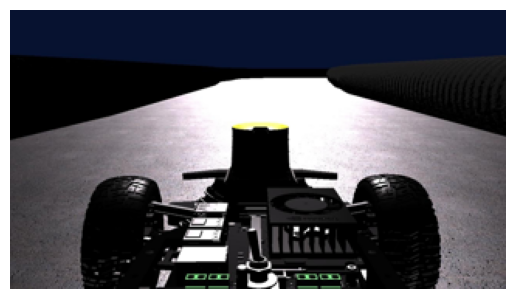

In [15]:
display_image_from_df(image_df, 0)

In [16]:
f110_path = "/content/drive/MyDrive/Dissertation/recorded_data_new.csv"

pd.set_option('display.max_columns', None)  # allow the notebook to show all columns

f110_data = pd.read_csv(f110_path)
print(f110_data.head())

                    timestamp  throttle  steering  encoder_ticks_left  \
0  2024-06-26 17:13:51.854077     0.285     0.032                1452   
1  2024-06-26 17:13:51.953301     0.286     0.031                2162   
2  2024-06-26 17:13:52.056838     0.287     0.027                2911   
3  2024-06-26 17:13:52.162178     0.289     0.023                3717   
4  2024-06-26 17:13:52.269002     0.291     0.019                4537   

   encoder_ticks_right  encoder_angles_left  encoder_angles_right  position_x  \
0                 1450                4.752                 4.745       0.741   
1                 2166                7.075                 7.088       0.743   
2                 2920                9.526                 9.556       0.748   
3                 3731               12.164                12.210       0.754   
4                 4555               14.847                14.906       0.763   

   position_y  position_z  orientation_quaternion_x  orientation_quaternio

In [17]:
columns_to_keep = [
    'steering',
    'lidar_ranges',
    'throttle'
] # img arrays will be added in after

for column in columns_to_keep:
    image_df[column] = f110_data[column]  # aka right here

del f110_data

In [18]:
print(image_df.head())

                                        image_arrays  steering  \
0  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...     0.032   
1  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...     0.031   
2  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...     0.027   
3  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...     0.023   
4  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...     0.019   

                                        lidar_ranges  throttle  
0  [0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...     0.285  
1  [0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...     0.286  
2  [0.7515233, 0.7485677, 0.7456495, 0.742768, 0....     0.287  
3  [0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...     0.289  
4  [0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...     0.291  


In [19]:
image_df.columns  # quadruple checking columns?

Index(['image_arrays', 'steering', 'lidar_ranges', 'throttle'], dtype='object')

In [ ]:
# Shuffle the dataset -> DON'T DO THIS FOR SEQUENTIAL DATA
# image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
image_df.head()  # split x and y for inputs and outputs

,image_arrays,steering,lidar_ranges,throttle
0,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...",0.032,"[0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...",0.285
1,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...",0.031,"[0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...",0.286
2,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...",0.027,"[0.7515233, 0.7485677, 0.7456495, 0.742768, 0....",0.287
3,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...",0.023,"[0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...",0.289
4,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...",0.019,"[0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...",0.291


In [21]:
X = image_df.drop(columns=['steering', 'throttle'])
y = image_df[['steering', 'throttle']]

del image_df

X.head()

,image_arrays,lidar_ranges
0,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7463607, 0.7432726, 0.7402241, 0.7372144, 0..."
1,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7474717, 0.7444539, 0.7414744, 0.7385327, 0..."
2,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7515233, 0.7485677, 0.7456495, 0.742768, 0...."
3,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7594686, 0.7573279, 0.7552136, 0.7531253, 0..."
4,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7948893, 0.7926978, 0.7905333, 0.7883955, 0..."


In [22]:
y.head()

,steering,throttle
0,0.032,0.285
1,0.031,0.286
2,0.027,0.287
3,0.023,0.289
4,0.019,0.291


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
del X
del y

In [24]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (4330, 2)
X_val shape: (1083, 2)
y_train shape: (4330, 2)
y_val shape: (1083, 2)


In [25]:
X_train.head()

,image_arrays,lidar_ranges
0,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7463607, 0.7432726, 0.7402241, 0.7372144, 0..."
1,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7474717, 0.7444539, 0.7414744, 0.7385327, 0..."
2,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7515233, 0.7485677, 0.7456495, 0.742768, 0...."
3,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7594686, 0.7573279, 0.7552136, 0.7531253, 0..."
4,"[[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...","[0.7948893, 0.7926978, 0.7905333, 0.7883955, 0..."


In [26]:
print(X_train['lidar_ranges'].head(10))
print(type(X_train['lidar_ranges'].iloc[0]))  # str lidar should be converted to floats

0    [0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...
1    [0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...
2    [0.7515233, 0.7485677, 0.7456495, 0.742768, 0....
3    [0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...
4    [0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...
5    [0.8320078, 0.8297573, 0.8275347, 0.8253398, 0...
6    [0.8707626, 0.8684419, 0.86615, 0.8638867, 0.8...
7    [0.9108087, 0.9084088, 0.9060387, 0.9036983, 0...
8    [0.952126, 0.9496343, 0.9471735, 0.9447433, 0....
9    [0.9945586, 0.9919606, 0.9893949, 0.9868612, 0...
Name: lidar_ranges, dtype: object
<class 'str'>


In [27]:
import pandas as pd
import numpy as np
import ast


def convert_string_to_array(string):
    try:
        # replace 'inf' with '0' and then safely evaluate the stringrep, replacing with inf bricks training
        string = string.replace('inf', '0')
        array = np.array(ast.literal_eval(string))
        return array
    except (ValueError, SyntaxError) as e:
        return np.array([])

# apply the function to 'lidar_ranges'
X_train['lidar_ranges'] = X_train['lidar_ranges'].apply(convert_string_to_array)
X_val['lidar_ranges'] = X_val['lidar_ranges'].apply(convert_string_to_array)

In [28]:
# sample of the lidar_ranges column
lidar_sample = X_train['lidar_ranges'].sample(10)

# get the minmax
min_values = []
max_values = []
for lst in lidar_sample:
    min_values.append(min(lst))
    max_values.append(max(lst))

# use this to understand the highest gap and if scaling is required
print(f"Min values in the sample: {min_values}")
print(f"Max values in the sample: {max_values}")
print(f"Overall min value: {min(min_values)}")
print(f"Overall max value: {max(max_values)}")

Min values in the sample: [0.6104421, 0.0, 0.0, 1.084603, 0.8353095, 0.0, 0.3230475, 0.7534035, 0.7459494, 0.3256174]
Max values in the sample: [7.917582, 9.595759, 9.851789, 4.713541, 4.638378, 9.5012, 3.744558, 5.870957, 5.526854, 4.151189]
Overall min value: 0.0
Overall max value: 9.851789


In [29]:
# verify postconverted dtypes
print(X_train['lidar_ranges'].head(10))
print(type(X_train['lidar_ranges'].iloc[0]))

print(X_val['lidar_ranges'].head(10))
print(type(X_val['lidar_ranges'].iloc[0]))

0    [0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...
1    [0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...
2    [0.7515233, 0.7485677, 0.7456495, 0.742768, 0....
3    [0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...
4    [0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...
5    [0.8320078, 0.8297573, 0.8275347, 0.8253398, 0...
6    [0.8707626, 0.8684419, 0.86615, 0.8638867, 0.8...
7    [0.9108087, 0.9084088, 0.9060387, 0.9036983, 0...
8    [0.952126, 0.9496343, 0.9471735, 0.9447433, 0....
9    [0.9945586, 0.9919606, 0.9893949, 0.9868612, 0...
Name: lidar_ranges, dtype: object
<class 'numpy.ndarray'>
4330    [0.4386624, 0.4363423, 0.4340548, 0.4317995, 0...
4331    [0.4268475, 0.4245924, 0.422369, 0.4201767, 0....
4332    [0.415131, 0.4129368, 0.4107734, 0.4086404, 0....
4333    [0.4400481, 0.438629, 0.4372274, 0.435843, 0.4...
4334    [0.453728, 0.4522599, 0.4508099, 0.4493777, 0....
4335    [0.4672702, 0.4657513, 0.4642511, 0.4627693, 0...
4336    [0.496038, 0.4945115, 0.4930037, 0.4

In [30]:
y_train.head()

,steering,throttle
0,0.032,0.285
1,0.031,0.286
2,0.027,0.287
3,0.023,0.289
4,0.019,0.291


In [31]:
print(X_train.columns)
print(y_train.columns)

Index(['image_arrays', 'lidar_ranges'], dtype='object')
Index(['steering', 'throttle'], dtype='object')


In [32]:
def display_column_types(df, name):
    print(f"Data types in {name}:")
    print(df.dtypes)
    print("\n")


# Convert ndarray columns to float32
ndarray_columns = ['lidar_ranges']
for col in ndarray_columns:
    X_train[col] = X_train[col].apply(lambda x: x.astype(np.float32) if isinstance(x, np.ndarray) else x)
    X_val[col] = X_val[col].apply(lambda x: x.astype(np.float32) if isinstance(x, np.ndarray) else x)

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# Display column types for each dataset
display_column_types(X_train, "X_train")
display_column_types(X_val, "X_val")
display_column_types(y_train, "y_train")
display_column_types(y_val, "y_val")

Data types in X_train:
image_arrays    object
lidar_ranges    object
dtype: object


Data types in X_val:
image_arrays    object
lidar_ranges    object
dtype: object


Data types in y_train:
steering    float32
throttle    float32
dtype: object


Data types in y_val:
steering    float32
throttle    float32
dtype: object




In [33]:
import numpy as np

def check_column_element_types(df, column_name):
    print(f"Checking types for column: {column_name}")
    for i, element in enumerate(df[column_name].head(10)):
        print(f"Element {i} type: {type(element)}")
        print(f"Element {i} length: {len(element)}")
        if len(element) == 0:
          print(element)

# recheck
check_column_element_types(X_train, 'lidar_ranges')
check_column_element_types(X_val, 'lidar_ranges')
check_column_element_types(X_train, 'image_arrays')
check_column_element_types(X_val, 'image_arrays')

Checking types for column: lidar_ranges
Element 0 type: <class 'numpy.ndarray'>
Element 0 length: 1081
Element 1 type: <class 'numpy.ndarray'>
Element 1 length: 1081
Element 2 type: <class 'numpy.ndarray'>
Element 2 length: 1081
Element 3 type: <class 'numpy.ndarray'>
Element 3 length: 1081
Element 4 type: <class 'numpy.ndarray'>
Element 4 length: 1081
Element 5 type: <class 'numpy.ndarray'>
Element 5 length: 1081
Element 6 type: <class 'numpy.ndarray'>
Element 6 length: 1081
Element 7 type: <class 'numpy.ndarray'>
Element 7 length: 1081
Element 8 type: <class 'numpy.ndarray'>
Element 8 length: 1081
Element 9 type: <class 'numpy.ndarray'>
Element 9 length: 1081
Checking types for column: lidar_ranges
Element 0 type: <class 'numpy.ndarray'>
Element 0 length: 1081
Element 1 type: <class 'numpy.ndarray'>
Element 1 length: 1081
Element 2 type: <class 'numpy.ndarray'>
Element 2 length: 1081
Element 3 type: <class 'numpy.ndarray'>
Element 3 length: 1081
Element 4 type: <class 'numpy.ndarray'

In [34]:
# resave all for loading to save RAM
np.savez_compressed('/content/drive/MyDrive/Dissertation/X_train_smol', **{c: X_train[c].values for c in X_train.columns})

In [35]:
del X_train

In [36]:
np.savez_compressed('/content/drive/MyDrive/Dissertation/X_val_smol', **{c: X_val[c].values for c in X_val.columns})

In [37]:
del X_val

In [38]:
np.savez_compressed('/content/drive/MyDrive/Dissertation/y_train_smol', **{c: y_train[c].values for c in y_train.columns})

In [39]:
del y_train

In [40]:
np.savez_compressed('/content/drive/MyDrive/Dissertation/y_val_smol', **{c: y_val[c].values for c in y_val.columns})

In [41]:
del y_val

# 3: Switching to PyTorch for training hybrid LSTM (Experiment):

In [1]:
# Mount my Drive to access the uploaded cam frames and sensor data CSV

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
data = np.load("/content/drive/MyDrive/Dissertation/X_train.npz", allow_pickle=True)
X_train = pd.DataFrame({file: data[file] for file in data.files})
del data
print(X_train.head())

data = np.load("/content/drive/MyDrive/Dissertation/X_val.npz", allow_pickle=True)
X_val = pd.DataFrame({file: data[file] for file in data.files})
del data
print(X_val.head())

data = np.load("/content/drive/MyDrive/Dissertation/y_train.npz", allow_pickle=True)
y_train = pd.DataFrame({file: data[file] for file in data.files})
del data
print(y_train.head())

data = np.load("/content/drive/MyDrive/Dissertation/y_val.npz", allow_pickle=True)
y_val = pd.DataFrame({file: data[file] for file in data.files})
del data
print(y_val.head())

                                        image_arrays  \
0  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
1  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
2  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
3  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
4  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   

                                        lidar_ranges  
0  [0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...  
1  [0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...  
2  [0.7515233, 0.7485677, 0.7456495, 0.742768, 0....  
3  [0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...  
4  [0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...  
                                        image_arrays  \
0  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
1  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
2  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
3  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ...   
4  [[[7.0, 18.0, 48.0], [7.0, 18.0, 48.0], [7.0, ... 

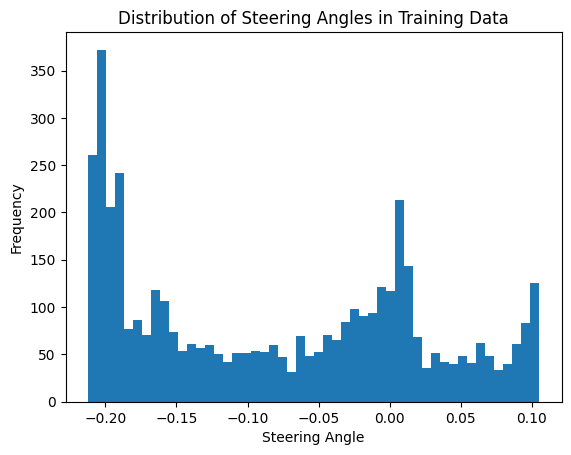

In [45]:
plt.hist(y_train['steering'], bins=50)  # sample steering dist
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.title('Distribution of Steering Angles in Training Data')
plt.show()

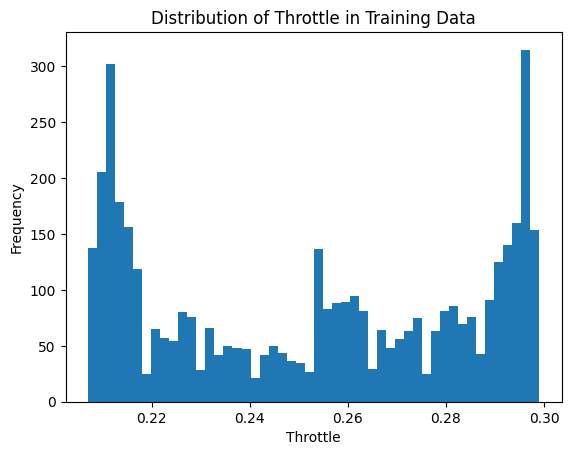

In [46]:
plt.hist(y_train['throttle'], bins=50)  # sample throttle dist
plt.xlabel('Throttle')
plt.ylabel('Frequency')
plt.title('Distribution of Throttle in Training Data')
plt.show()

In [4]:
# assert dtype into array
y_train_steering = y_train['steering'].values
y_train_throttle = y_train['throttle'].values
y_val_steering = y_val['steering'].values
y_val_throttle = y_val['throttle'].values

# stack for processing
y_train = np.column_stack((y_train_steering, y_train_throttle))
y_val = np.column_stack((y_val_steering, y_val_throttle))

# convert dframe to npy array
X_train_images = np.stack(X_train['image_arrays'].values)
X_train_lidars = np.stack(X_train['lidar_ranges'].values)
X_val_images = np.stack(X_val['image_arrays'].values)
X_val_lidars = np.stack(X_val['lidar_ranges'].values)

# check shapes
print(f'Original X_train_images shape: {X_train_images.shape}')
print(f'Original X_train_lidars shape: {X_train_lidars.shape}')
print(f'Original X_val_images shape: {X_val_images.shape}')
print(f'Original X_val_lidars shape: {X_val_lidars.shape}')
print(f'Original y_train shape: {y_train.shape}')
print(f'Original y_val shape: {y_val.shape}')

Original X_train_images shape: (4330, 360, 640, 3)
Original X_train_lidars shape: (4330, 1081)
Original X_val_images shape: (1083, 360, 640, 3)
Original X_val_lidars shape: (1083, 1081)
Original y_train shape: (4330, 2)
Original y_val shape: (1083, 2)


In [48]:
print(y_train[:5])  # the columns should be stacked into an array of arrays

[[0.032 0.285]
 [0.031 0.286]
 [0.027 0.287]
 [0.023 0.289]
 [0.019 0.291]]


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SteeringDataset(Dataset):  # feed data in batches to avoid crashes
    def __init__(self, images, lidars, targets, seq_length):
        self.images = images
        self.lidars = lidars
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.images) - self.seq_length + 1

    def __getitem__(self, idx):
        image_seq = self.images[idx:idx + self.seq_length].astype(np.float32) / 255.0
        lidar_seq = self.lidars[idx:idx + self.seq_length].astype(np.float32) / 10.0
        target = self.targets[idx + self.seq_length - 1].astype(np.float32)  # predict target for the last time step

        image_seq_tensor = torch.tensor(image_seq).permute(0, 3, 1, 2)  # adjust dims to [seq_length, channels, height, width]
        lidar_seq_tensor = torch.tensor(lidar_seq)
        target_tensor = torch.tensor(target)

        return image_seq_tensor, lidar_seq_tensor, target_tensor

seq_length = 10  # sliding window

# create datasets
train_dataset = SteeringDataset(X_train_images, X_train_lidars, y_train, seq_length)
val_dataset = SteeringDataset(X_val_images, X_val_lidars, y_val, seq_length)

# create data loaders from datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# verify these shapes (should be torch types)
for image_seq, lidar_seq, target in train_loader:
    print(f'Image sequence shape: {image_seq.shape}')
    print(f'Lidar sequence shape: {lidar_seq.shape}')
    print(f'Target shape: {target.shape}')
    break

Image sequence shape: torch.Size([32, 10, 3, 360, 640])
Lidar sequence shape: torch.Size([32, 10, 1081])
Target shape: torch.Size([32, 2])


In [6]:
# ORIGINAL SIZE
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeDistributedCNN(nn.Module):
    def __init__(self):
        super(TimeDistributedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()

        # calculate the output size after convolution layers
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()

        # adjust the dimensions to match the expected input size of LSTM
        self.fc = nn.Linear(self._to_linear, 100)

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 360, 640)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        return x

class CNNLSTMModel(nn.Module):
    def __init__(self, seq_length):
        super(CNNLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = TimeDistributedCNN()
        self.lstm_image = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64 * 2, 2)  # output 2 values: steering and throttle

    def forward(self, x_image, x_lidar):
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.fc(x)
        return x

model = CNNLSTMModel(seq_length=10).cuda()
print(model)

CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
      (2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
      (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (fc): Linear(in_features=177536, out_features=100, bias=True)
  )
  (lstm_image): LSTM(100, 64, batch_first=True)
  (lstm_lidar): LSTM(1081, 64, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [6]:
# SCALED MODEL

import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeDistributedCNN(nn.Module):
    def __init__(self):
        super(TimeDistributedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()

        # calculate the output size after convolution layers
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()

        # adjust the dimensions to match the expected input size of LSTM
        self.fc = nn.Linear(self._to_linear, 100)

    def _get_conv_output(self):
        with torch.no_grad():
            # update the size here
            x = torch.randn(1, 3, 180, 320)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        return x

class CNNLSTMModel(nn.Module):
    def __init__(self, seq_length):
        super(CNNLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = TimeDistributedCNN()
        self.lstm_image = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64 * 2, 2)  # output 2 values: steering and throttle

    def forward(self, x_image, x_lidar):
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTMModel(seq_length=10).to(device)
print(model)

CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
      (2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
      (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (fc): Linear(in_features=31680, out_features=100, bias=True)
  )
  (lstm_image): LSTM(100, 64, batch_first=True)
  (lstm_lidar): LSTM(1081, 64, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [7]:
import matplotlib.pyplot as plt

class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, num_epochs, device='cuda'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        self.device = torch.device(device)
        self.model.to(self.device)
        self.history = {'train_loss': [], 'val_loss': []}

    def train(self):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0

            self.model.train()
            for images_seq, lidars_seq, targets in self.train_loader:
                images_seq, lidars_seq, targets = images_seq.to(self.device), lidars_seq.to(self.device), targets.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images_seq, lidars_seq)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            train_loss /= len(self.train_loader)  # divide by the current loader
            self.history['train_loss'].append(train_loss)

            self.model.eval()
            with torch.no_grad():
                for images_seq, lidars_seq, targets in self.val_loader:
                    images_seq, lidars_seq, targets = images_seq.to(self.device), lidars_seq.to(self.device), targets.to(self.device)
                    outputs = self.model(images_seq, lidars_seq)
                    loss = self.criterion(outputs, targets)
                    val_loss += loss.item()

            val_loss /= len(self.val_loader)
            self.history['val_loss'].append(val_loss)

            print(f"Epoch {epoch+1}/{self.num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    def plot_training_history(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_predictions(self, y_val):
        self.model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for images_seq, lidars_seq, targets in self.val_loader:
                images_seq, lidars_seq = images_seq.to(self.device), lidars_seq.to(self.device)
                outputs = self.model(images_seq, lidars_seq)
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        plt.figure(figsize=(10, 5))
        plt.plot(all_targets[:, 0], label='Actual Steering')
        plt.plot(all_preds[:, 0], label='Predicted Steering')
        plt.xlabel('Sample')
        plt.ylabel('Steering Angle')
        plt.legend()
        plt.title('Actual vs Predicted Steering Angle')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(all_targets[:, 1], label='Actual Throttle')
        plt.plot(all_preds[:, 1], label='Predicted Throttle')
        plt.xlabel('Sample')
        plt.ylabel('Throttle')
        plt.legend()
        plt.title('Actual vs Predicted Throttle')
        plt.show()

Epoch 1/10, Training Loss: 0.0017, Validation Loss: 0.0001
Epoch 2/10, Training Loss: 0.0001, Validation Loss: 0.0002
Epoch 3/10, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 4/10, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 5/10, Training Loss: 0.0002, Validation Loss: 0.0001
Epoch 6/10, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 7/10, Training Loss: 0.0000, Validation Loss: 0.0001
Epoch 8/10, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 9/10, Training Loss: 0.0001, Validation Loss: 0.0001
Epoch 10/10, Training Loss: 0.0000, Validation Loss: 0.0000


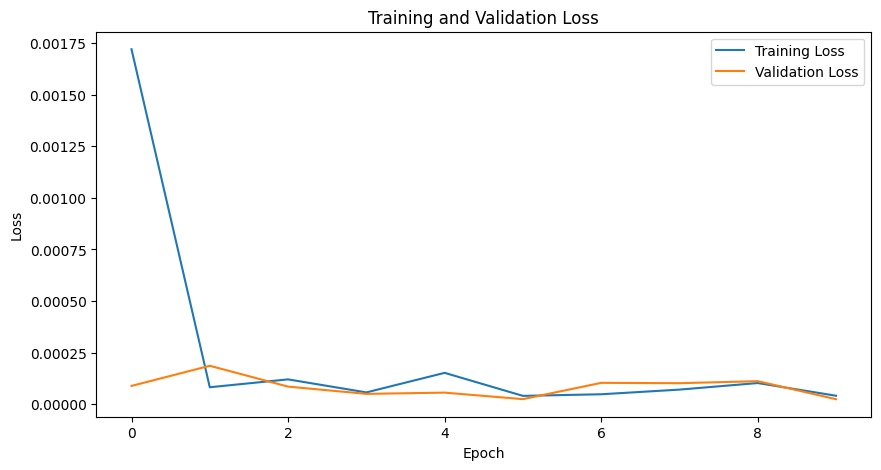

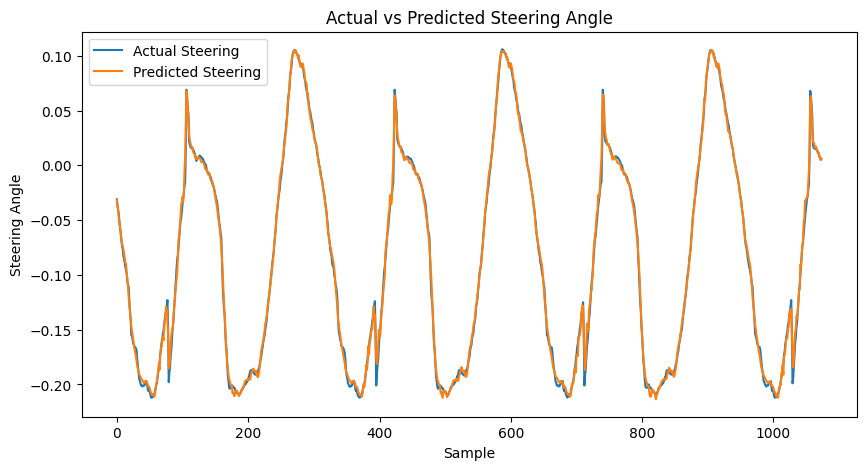

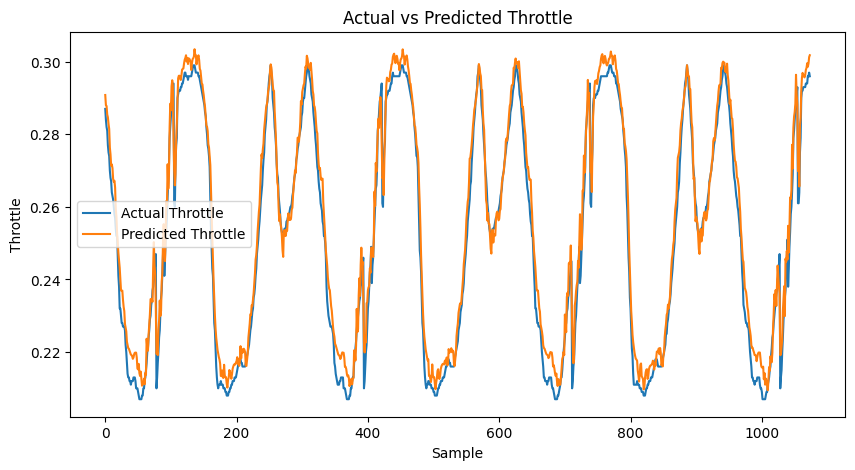

In [8]:
model = CNNLSTMModel(seq_length=10).cuda()
trainer = ModelTrainer(model, train_loader, val_loader, num_epochs=10)

trainer.train()

trainer.plot_training_history()
trainer.plot_predictions(y_val)

# this whole block is used for both the baseline and the image scaling model
torch.save(model.state_dict(), '/content/drive/MyDrive/Dissertation/orpheus_smol.pth')

In [9]:
# sample acc test
for images_seq, lidars_seq, actual_targets in val_loader:
    break 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# first sample only
images_seq = images_seq[0].unsqueeze(0).to(device)  # add batch dimension
lidars_seq = lidars_seq[0].unsqueeze(0).to(device)  # add batch dimension
actual_target = actual_targets[0].cpu().numpy()

print(f"Image input length: {images_seq.size()}")
print(f"Lidar input length: {lidars_seq.size()}")
print(f"Actual output: {actual_target}")

# make a prediction using the model
with torch.no_grad():
    predicted_target = model(images_seq, lidars_seq).cpu().numpy()

print(f"Predicted Steering Angle: {predicted_target[0, 0]:.4f}")
print(f"Actual Steering Angle: {actual_target[0]:.4f}")
print(f"Predicted Throttle: {predicted_target[0, 1]:.4f}")
print(f"Actual Throttle: {actual_target[1]:.4f}")

Image input length: torch.Size([1, 10, 3, 180, 320])
Lidar input length: torch.Size([1, 10, 1081])
Actual output: [-0.031  0.287]
Predicted Steering Angle: -0.0318
Actual Steering Angle: -0.0310
Predicted Throttle: 0.2908
Actual Throttle: 0.2870


**NOTE: This block is reused**.
This whole pipeline is reused between the baseline (640x360) and the image scaling method (320x180). All the way from Part 1 where the images are saved smaller for preprocessing into a smaller data file which is in turn saved and re loaded and re processed for use with the scaled model, just by swapping values at the right places.

# 4: Quantisation Approaches: Hybrid Post Training Quantisation
### Note: Run this section after 3. to apply Hybrid PTQ (to the baseline). The next section will apply QAT separately.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeDistributedCNN(nn.Module):
    def __init__(self):
        super(TimeDistributedCNN, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()

        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()

        self.fc = nn.Linear(self._to_linear, 100)
        self.dequant = torch.quantization.DeQuantStub()

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 360, 640)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.quant(x)
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        x = self.dequant(x)
        return x

class CNNLSTMModel(nn.Module):
    def __init__(self, seq_length):
        super(CNNLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = TimeDistributedCNN()
        self.lstm_image = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64 * 2, 2)  # Output 2 values: steering and throttle
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x_image, x_lidar):
        x_image = self.quant(x_image)
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar = self.quant(x_lidar)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.dequant(x)
        x = self.fc(x)
        return x

# added quant and dequant stubs to the og baseline

In [ ]:
trained_weights_path = '/content/drive/MyDrive/Dissertation/orpheus_torch.pth'  # load the original model
# loading the old model works even with quantstubs as they don't change the architecture

hybrid_ptq_model = CNNLSTMModel(seq_length=10).cpu()
hybrid_ptq_model.load_state_dict(torch.load(trained_weights_path))

print(hybrid_ptq_model)

CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (quant): QuantStub()
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
      (2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
      (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (fc): Linear(in_features=177536, out_features=100, bias=True)
    (dequant): DeQuantStub()
  )
  (lstm_image): LSTM(100, 64, batch_first=True)
  (lstm_lidar): LSTM(1081, 64, batch_first=True)
  (fc): Linear(in_feat

In [ ]:
import torch
import torch.nn as nn
import torch.quantization
import io

# assuming the model is defined and loaded
torch.backends.quantized.engine = 'qnnpack'  # for cpu and macos

print("Prepping Static PTQ")
# static ptq for the CNN part using the default qconfig for 'qnnpack'
hybrid_ptq_model.time_distributed_cnn.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')
torch.ao.quantization.prepare(hybrid_ptq_model.time_distributed_cnn, inplace=True)

print("Calibrating the model with samples")
# calibrate the model with a few batches of data
hybrid_ptq_model.eval()
with torch.no_grad():
    for i, (image_seq, lidar_seq, target) in enumerate(train_loader):
        hybrid_ptq_model(image_seq.cpu(), lidar_seq.cpu())
        if i == 9:
            break

print("Applying Static PTQ to Conv Layers")
# convert the CNN part to a quantized version
torch.ao.quantization.convert(hybrid_ptq_model.time_distributed_cnn, inplace=True)

print("Applying Dynamic PTQ to the LSTMs")
# dynamic ptq for the LSTM part
hybrid_ptq_model.lstm_image.qconfig = torch.quantization.default_dynamic_qconfig
hybrid_ptq_model.lstm_lidar.qconfig = torch.quantization.default_dynamic_qconfig
hybrid_ptq_model.lstm_image = torch.quantization.quantize_dynamic(hybrid_ptq_model.lstm_image, {nn.LSTM}, dtype=torch.qint8)
hybrid_ptq_model.lstm_lidar = torch.quantization.quantize_dynamic(hybrid_ptq_model.lstm_lidar, {nn.LSTM}, dtype=torch.qint8)

print("Saving the model")
torch.save(hybrid_ptq_model.state_dict(), f"/content/drive/MyDrive/Dissertation/hybrid_ptq.pth")
print("Scripted model saved")

Prepping Static PTQ
Calibrating the model with samples
Applying Static PTQ to Conv Layers
Applying Dynamic PTQ to the LSTMs
Saving the model
Scripted model saved


In [ ]:
# dtypes should be int8 post quant:
# convolutional layers - should show int8 due to ptsq's inplace conversion
def verify_conv_quantization(model):
    for name, module in model.named_modules():
      if hasattr(module, 'weight'):
        try:
            print(f'{name}: {module.weight().dtype}')
        except TypeError:
          pass

verify_conv_quantization(hybrid_ptq_model)

# LSTM layers - will still show float32 due to ptdq's on the fly conversion
def verify_lstm_quantization(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.LSTM):
            if hasattr(module, 'weight_ih_l0') and module.weight_ih_l0 is not None:
                print(f'{name}.weight_ih_l0: {module.weight_ih_l0.dtype}')
            if hasattr(module, 'weight_hh_l0') and module.weight_hh_l0 is not None:
                print(f'{name}.weight_hh_l0: {module.weight_hh_l0.dtype}')

verify_lstm_quantization(hybrid_ptq_model)

time_distributed_cnn.conv1: torch.qint8
time_distributed_cnn.conv2: torch.qint8
time_distributed_cnn.conv3: torch.qint8
time_distributed_cnn.conv4: torch.qint8
time_distributed_cnn.conv5: torch.qint8
time_distributed_cnn.convs.0: torch.qint8
time_distributed_cnn.convs.1: torch.qint8
time_distributed_cnn.convs.2: torch.qint8
time_distributed_cnn.convs.3: torch.qint8
time_distributed_cnn.convs.4: torch.qint8
time_distributed_cnn.fc: torch.qint8
lstm_image.weight_ih_l0: torch.float32
lstm_image.weight_hh_l0: torch.float32
lstm_lidar.weight_ih_l0: torch.float32
lstm_lidar.weight_hh_l0: torch.float32


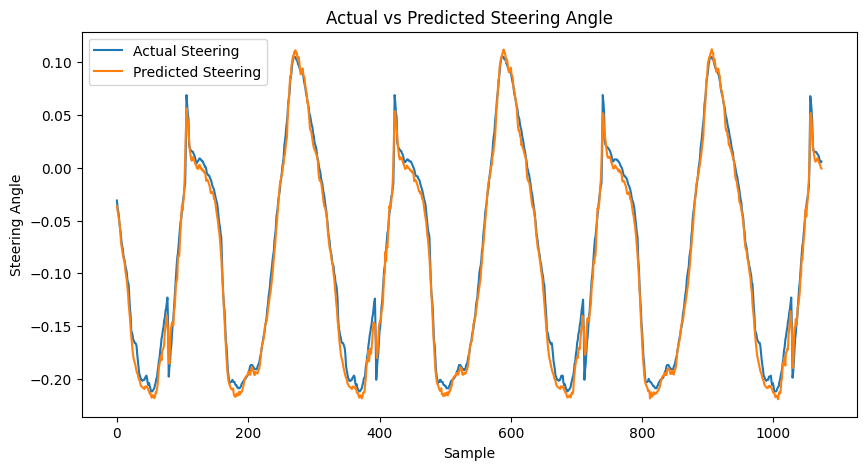

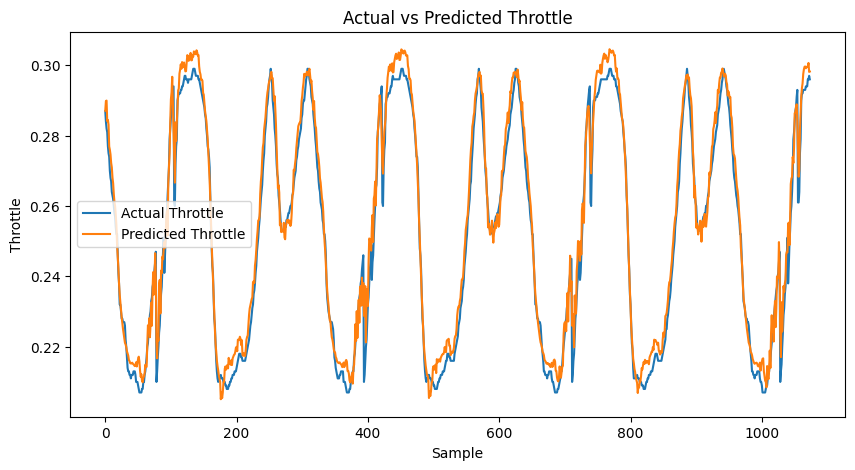

In [ ]:
hybrid_ptq_model.to('cpu')

eval = ModelTrainer(hybrid_ptq_model, train_loader, val_loader, num_epochs=10, device='cpu')
eval.plot_predictions(y_val)

These preds look good for testing. QAT is up next.

# 5. Quantisation Aware Training for GPU inference

### This currently only runs on CPU on Apple Silicon but still improves performance

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TimeDistributedCNN(nn.Module):
    def __init__(self):
        super(TimeDistributedCNN, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()

        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()
        self.fc = nn.Linear(self._to_linear, 100)
        self.dequant = torch.quantization.DeQuantStub()

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 360, 640)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.quant(x)
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        x = self.dequant(x)
        return x


class CNNLSTMModel(nn.Module):
    def __init__(self, seq_length):
        super(CNNLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = TimeDistributedCNN()
        self.lstm_image = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64 * 2, 2)

    def forward(self, x_image, x_lidar):
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.fc(x)
        return x


# almost the same setup as ptq, the difference is in the setup
qat_model = CNNLSTMModel(seq_length=10).cuda()
print(qat_model)

CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (quant): QuantStub()
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
      (2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
      (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (fc): Linear(in_features=177536, out_features=100, bias=True)
    (dequant): DeQuantStub()
  )
  (lstm_image): LSTM(100, 64, batch_first=True)
  (lstm_lidar): LSTM(1081, 64, batch_first=True)
  (fc): Linear(in_feat

In [45]:
torch.backends.quantized.engine = 'qnnpack'

qat_qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')

# apply the QAT configuration to the model
qat_model.time_distributed_cnn.qconfig = qat_qconfig

# prep the model for QAT
torch.quantization.prepare_qat(qat_model.time_distributed_cnn, inplace=True)

TimeDistributedCNN(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([0.0039], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=255, qscheme=torch.per_tensor_affine, reduce_range=False
      (activation_post_process): MovingAverageMinMaxObserver(min_val=0.0, max_val=1.0)
    )
  )
  (conv1): Conv2d(
    3, 24, kernel_size=(5, 5), stride=(2, 2)
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([0.0010], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_tensor_symmetric, reduce_range=False
      (activation_post_process): MovingAverageMinMaxObserver(min_val

In [38]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (image_seq, lidar_seq, target) in enumerate(train_loader):
            image_seq, lidar_seq, target = image_seq.to(device), lidar_seq.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(image_seq, lidar_seq)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.5f}')
                running_loss = 0.0


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(qat_model.parameters(), lr=0.001)
device = torch.device('cuda')
train(qat_model, train_loader, criterion, optimizer, num_epochs=10)

[Epoch 1, Batch 10] loss: 0.00283
[Epoch 1, Batch 20] loss: 0.00117
[Epoch 1, Batch 30] loss: 0.00039
[Epoch 1, Batch 40] loss: 0.00035
[Epoch 1, Batch 50] loss: 0.00034
[Epoch 1, Batch 60] loss: 0.00022
[Epoch 1, Batch 70] loss: 0.00023
[Epoch 1, Batch 80] loss: 0.00019
[Epoch 1, Batch 90] loss: 0.00012
[Epoch 1, Batch 100] loss: 0.00013
[Epoch 1, Batch 110] loss: 0.00014
[Epoch 1, Batch 120] loss: 0.00013
[Epoch 1, Batch 130] loss: 0.00011


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[Epoch 2, Batch 10] loss: 0.00024
[Epoch 2, Batch 20] loss: 0.00035
[Epoch 2, Batch 30] loss: 0.00025
[Epoch 2, Batch 40] loss: 0.00015
[Epoch 2, Batch 50] loss: 0.00031
[Epoch 2, Batch 60] loss: 0.00060
[Epoch 2, Batch 70] loss: 0.00027
[Epoch 2, Batch 80] loss: 0.00023
[Epoch 2, Batch 90] loss: 0.00019
[Epoch 2, Batch 100] loss: 0.00010
[Epoch 2, Batch 110] loss: 0.00010
[Epoch 2, Batch 120] loss: 0.00007
[Epoch 2, Batch 130] loss: 0.00006
[Epoch 3, Batch 10] loss: 0.00007
[Epoch 3, Batch 20] loss: 0.00006
[Epoch 3, Batch 30] loss: 0.00008
[Epoch 3, Batch 40] loss: 0.00008
[Epoch 3, Batch 50] loss: 0.00006
[Epoch 3, Batch 60] loss: 0.00006
[Epoch 3, Batch 70] loss: 0.00005
[Epoch 3, Batch 80] loss: 0.00005
[Epoch 3, Batch 90] loss: 0.00008
[Epoch 3, Batch 100] loss: 0.00012
[Epoch 3, Batch 110] loss: 0.00009
[Epoch 3, Batch 120] loss: 0.00006
[Epoch 3, Batch 130] loss: 0.00009
[Epoch 4, Batch 10] loss: 0.00021
[Epoch 4, Batch 20] loss: 0.00017
[Epoch 4, Batch 30] loss: 0.00012
[Epoch

In [46]:
# convert the model to a qat version, as qat trains with float and then quantises
qat_model.eval()
qat_model.cpu()
torch.ao.quantization.convert(qat_model.time_distributed_cnn, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


TimeDistributedCNN(
  (quant): Quantize(scale=tensor([0.0039]), zero_point=tensor([0]), dtype=torch.quint8)
  (conv1): QuantizedConv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
  (conv2): QuantizedConv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
  (conv3): QuantizedConv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
  (conv4): QuantizedConv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0)
  (conv5): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convs): Sequential(
    (0): QuantizedConv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
    (1): QuantizedConv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
    (2): QuantizedConv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
    (3): QuantizedConv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), sca

In [47]:
# convolutional layers - should also show int8 as before
def verify_conv_quantization(model):
    for name, module in model.named_modules():
      if hasattr(module, 'weight'):
        try:
            print(f'{name}: {module.weight().dtype}')
        except TypeError:
          pass

verify_conv_quantization(qat_model)

# LSTM layers - untouched this time around
def verify_lstm_quantization(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.LSTM):
            if hasattr(module, 'weight_ih_l0') and module.weight_ih_l0 is not None:
                print(f'{name}.weight_ih_l0: {module.weight_ih_l0.dtype}')
            if hasattr(module, 'weight_hh_l0') and module.weight_hh_l0 is not None:
                print(f'{name}.weight_hh_l0: {module.weight_hh_l0.dtype}')

verify_lstm_quantization(qat_model)

time_distributed_cnn.conv1: torch.qint8
time_distributed_cnn.conv2: torch.qint8
time_distributed_cnn.conv3: torch.qint8
time_distributed_cnn.conv4: torch.qint8
time_distributed_cnn.conv5: torch.qint8
time_distributed_cnn.convs.0: torch.qint8
time_distributed_cnn.convs.1: torch.qint8
time_distributed_cnn.convs.2: torch.qint8
time_distributed_cnn.convs.3: torch.qint8
time_distributed_cnn.convs.4: torch.qint8
time_distributed_cnn.fc: torch.qint8
lstm_image.weight_ih_l0: torch.float32
lstm_image.weight_hh_l0: torch.float32
lstm_lidar.weight_ih_l0: torch.float32
lstm_lidar.weight_hh_l0: torch.float32


In [48]:
print("Saving the model")
torch.save(qat_model.state_dict(), f"/content/drive/MyDrive/Dissertation/qat.pth")
print("Model saved")

Saving the model
Scripted model saved


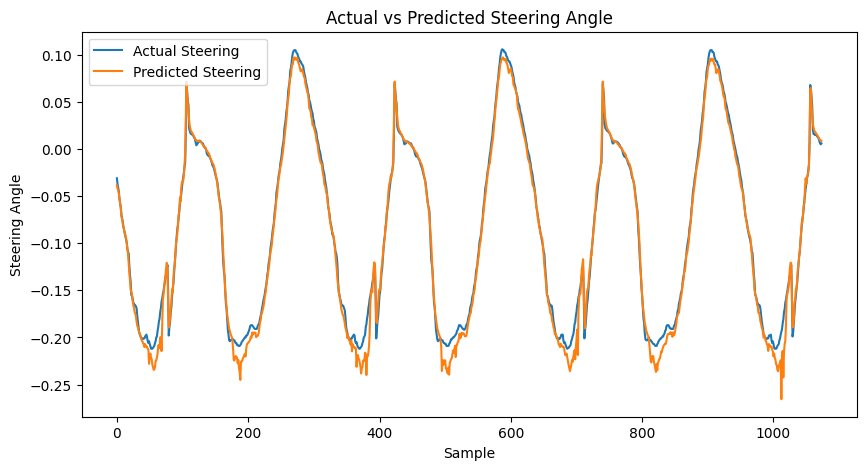

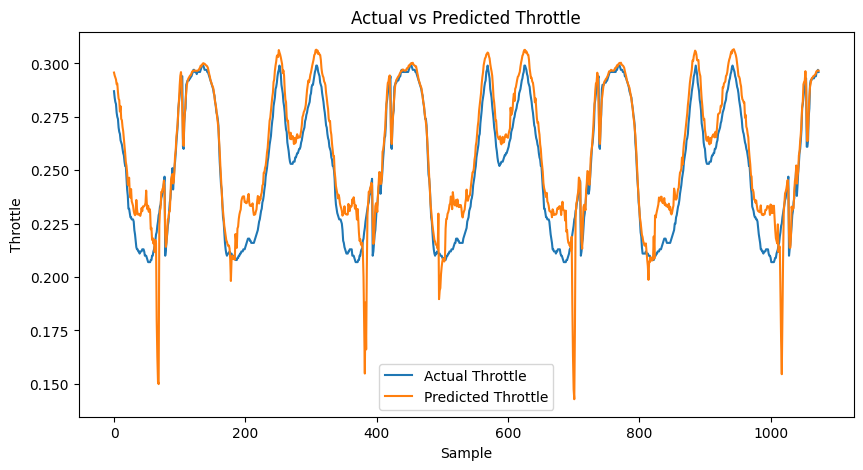

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_validation_accuracy(model, val_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images_seq, lidars_seq, targets in val_loader:
            images_seq, lidars_seq = images_seq.to(device), lidars_seq.to(device)
            outputs = model(images_seq, lidars_seq)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Plot Steering Angle
    plt.figure(figsize=(10, 5))
    plt.plot(all_targets[:, 0], label='Actual Steering')
    plt.plot(all_preds[:, 0], label='Predicted Steering')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle')
    plt.legend()
    plt.title('Actual vs Predicted Steering Angle')
    plt.show()

    # Plot Throttle
    plt.figure(figsize=(10, 5))
    plt.plot(all_targets[:, 1], label='Actual Throttle')
    plt.plot(all_preds[:, 1], label='Predicted Throttle')
    plt.xlabel('Sample')
    plt.ylabel('Throttle')
    plt.legend()
    plt.title('Actual vs Predicted Throttle')
    plt.show()

device = torch.device('cpu')
plot_validation_accuracy(qat_model, val_loader, device)

Shows good accuracy as before and also shows a larger range in predictions for throttle showing generalisation.

# 6: Base Model Pruning: Run this after #3

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim

In [10]:
import torch.nn.utils.prune as prune

def apply_pruning(model, amount, architecture):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            print(f"Pruning {module}")
            prune.remove(module, 'weight')  # perma remove the weight mask

            architecture[name] = {  # test stuff for modifying arc according to sparse tensors (unused)
                'in_channels': module.in_channels if hasattr(module, 'in_channels') else module.in_features,
                'out_channels': module.out_channels if hasattr(module, 'out_channels') else module.out_features,
                'kernel_size': module.kernel_size if hasattr(module, 'kernel_size') else None,
                'stride': module.stride if hasattr(module, 'stride') else None,
                'padding': module.padding if hasattr(module, 'padding') else None,
                'dilation': module.dilation if hasattr(module, 'dilation') else None,
                'groups': module.groups if hasattr(module, 'groups') else None
            }

Pruning Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
Pruning Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
Applied pruning at epoch 0
Epoch 1/10, Train Loss: 0.0042, Validation Loss: 0.0001
Pruning Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
Pruning Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
Applied pruning at epoch 1
Epoch 2/10, Train Loss: 0.0001, Validation Loss: 0.0001
Pruning Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
Pruning Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
Pruning Conv2d(64, 64, ke

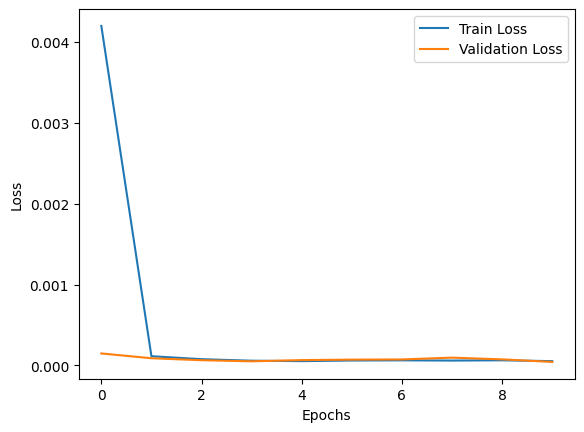

In [14]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json

def train_with_pruning(model, train_loader, val_loader, num_epochs, device='cuda', pruning_amount=0.2, prune_every_n_epochs=1):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []
    architecture = {}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs_image, inputs_lidar, labels = data
            inputs_image, inputs_lidar, labels = inputs_image.to(device), inputs_lidar.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs_image, inputs_lidar)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Apply pruning
        if epoch % prune_every_n_epochs == 0:
            apply_pruning(model, pruning_amount, architecture)
            print(f'Applied pruning at epoch {epoch}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs_image, inputs_lidar, labels = data
                inputs_image, inputs_lidar, labels = inputs_image.to(device), inputs_lidar.to(device), labels.to(device)

                outputs = model(inputs_image, inputs_lidar)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # plotting the training and validation loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, architecture


model = CNNLSTMModel(seq_length=10)
pruned_model, architecture = train_with_pruning(model, train_loader, val_loader, num_epochs=10, pruning_amount=0.5, prune_every_n_epochs=1)

In [16]:
print(architecture)

{'time_distributed_cnn.conv1': {'in_channels': 3, 'out_channels': 24, 'kernel_size': (5, 5), 'stride': (2, 2), 'padding': (0, 0), 'dilation': (1, 1), 'groups': 1}, 'time_distributed_cnn.conv2': {'in_channels': 24, 'out_channels': 36, 'kernel_size': (5, 5), 'stride': (2, 2), 'padding': (0, 0), 'dilation': (1, 1), 'groups': 1}, 'time_distributed_cnn.conv3': {'in_channels': 36, 'out_channels': 48, 'kernel_size': (5, 5), 'stride': (2, 2), 'padding': (0, 0), 'dilation': (1, 1), 'groups': 1}, 'time_distributed_cnn.conv4': {'in_channels': 48, 'out_channels': 64, 'kernel_size': (3, 3), 'stride': (1, 1), 'padding': (0, 0), 'dilation': (1, 1), 'groups': 1}, 'time_distributed_cnn.conv5': {'in_channels': 64, 'out_channels': 64, 'kernel_size': (3, 3), 'stride': (1, 1), 'padding': (0, 0), 'dilation': (1, 1), 'groups': 1}}


In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Dissertation/pruned_model.pth')
with open('/content/drive/MyDrive/Dissertation/pruned_architecture.json', 'w') as f:
    json.dump(architecture, f)

Unusably bad, but carry on test.

Test if we can load back a pruned model based on saved architecture

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the new pruned model architecture directly
class PrunedTimeDistributedCNN(nn.Module):
    def __init__(self):
        super(PrunedTimeDistributedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0), dilation=(1, 1), groups=1)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0), dilation=(1, 1), groups=1)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0), dilation=(1, 1), groups=1)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1, 1), groups=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1, 1), groups=1)
        self.flatten = nn.Flatten()

        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()
        self.fc = nn.Linear(self._to_linear, 100)

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 360, 640)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.convs(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        return x

class PrunedCNNLSTMModel(nn.Module):
    def __init__(self, seq_length):
        super(PrunedCNNLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = PrunedTimeDistributedCNN()
        self.lstm_image = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64 * 2, 2)  # Output 2 values: steering and throttle

    def forward(self, x_image, x_lidar):
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.fc(x)
        return x

# load pruned model state dict and architecture
def load_pruned_model(state_dict_path, arch_path):
    with open(arch_path, 'r') as f:
        pruned_architecture = json.load(f)
    model = CNNLSTMModel(seq_length=10, conv_layers=pruned_architecture)
    state_dict = torch.load(state_dict_path)

    new_state_dict = {}
    for key in state_dict:
        new_key = key.replace("time_distributed_cnn.convs.", "time_distributed_cnn.")
        new_state_dict[new_key] = state_dict[key]

    model.load_state_dict(new_state_dict)
    return model

state_dict_path = '/content/drive/MyDrive/Dissertation/pruned_model.pth'
arch_path = '/content/drive/MyDrive/Dissertation/pruned_architecture.json'

# load the pruned model
pruned_model_loaded = load_pruned_model(state_dict_path, arch_path)
print(pruned_model_loaded)

RuntimeError: Error(s) in loading state_dict for PrunedCNNLSTMModel:
	While copying the parameter named "time_distributed_cnn.conv1.weight", whose dimensions in the model are torch.Size([24, 3, 5, 5]) and whose dimensions in the checkpoint are torch.Size([24, 3, 5, 5]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.conv2.weight", whose dimensions in the model are torch.Size([36, 24, 5, 5]) and whose dimensions in the checkpoint are torch.Size([36, 24, 5, 5]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.conv3.weight", whose dimensions in the model are torch.Size([48, 36, 5, 5]) and whose dimensions in the checkpoint are torch.Size([48, 36, 5, 5]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.conv4.weight", whose dimensions in the model are torch.Size([64, 48, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 48, 3, 3]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.conv5.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.convs.0.weight", whose dimensions in the model are torch.Size([24, 3, 5, 5]) and whose dimensions in the checkpoint are torch.Size([24, 3, 5, 5]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.convs.1.weight", whose dimensions in the model are torch.Size([36, 24, 5, 5]) and whose dimensions in the checkpoint are torch.Size([36, 24, 5, 5]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.convs.2.weight", whose dimensions in the model are torch.Size([48, 36, 5, 5]) and whose dimensions in the checkpoint are torch.Size([48, 36, 5, 5]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.convs.3.weight", whose dimensions in the model are torch.Size([64, 48, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 48, 3, 3]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).
	While copying the parameter named "time_distributed_cnn.convs.4.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('copy_() between dense and sparse Tensors is not implemented! Found self type = torch.FloatTensor and src type = torch.cuda.sparse.FloatTensor',).

In [10]:
def evaluate_pruned_model(model, val_loader, criterion, device):
    model.to(device)
    model.eval()  # set the model to evaluation mode

    val_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in val_loader:
            x_image, x_lidar, targets = batch
            x_image = x_image.to(device)
            x_lidar = x_lidar.to(device)
            targets = targets.to(device)

            outputs = model(x_image, x_lidar)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss}')

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # plot predictions vs targets
    plt.figure(figsize=(10, 5))
    plt.plot(all_targets[:, 0], label='True Steering')
    plt.plot(all_predictions[:, 0], label='Predicted Steering')
    plt.plot(all_targets[:, 1], label='True Throttle')
    plt.plot(all_predictions[:, 1], label='Predicted Throttle')
    plt.legend()
    plt.title('Model Predictions vs True Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.show()

    return val_loss

The reconstituted arch is incompatible when pruning during training and pruning post training does nothing (Unstructured).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
evaluate_pruned_model(pruned_model_loaded, val_loader, criterion, device)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def fine_tune_pruned_model(pruned_model, train_loader, val_loader, num_epochs, device='cuda'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(pruned_model.parameters(), lr=0.001)

    pruned_model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        pruned_model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            x_image, x_lidar, targets = batch
            x_image = x_image.to(device)
            x_lidar = x_lidar.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = pruned_model(x_image, x_lidar)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

        pruned_model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x_image, x_lidar, targets = batch
                x_image = x_image.to(device)
                x_lidar = x_lidar.to(device)
                targets = targets.to(device)

                outputs = pruned_model(x_image, x_lidar)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


    # plot training and validation loss
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return pruned_model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fine_tuned_model = fine_tune_pruned_model(pruned_model_loaded, train_loader, val_loader, num_epochs=5, device=device)
evaluate_pruned_model(fine_tuned_model, val_loader, criterion, device)

torch.save(fine_tuned_model.state_dict(), '/content/drive/MyDrive/Dissertation/pruned_model.pth')

Structured Pruning Test

In [12]:
!pip install torch-pruning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [13]:
import torch_pruning as tp

def prune_model(model, example_inputs, amount=0.5):  # prune down to half
    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            num_prune = int(module.out_channels * amount)
            if num_prune == 0:
                continue
            pruning_idxs = list(range(num_prune))
            group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=pruning_idxs)

            if DG.check_pruning_group(group):
                group.prune()
                print(f"Pruned {num_prune} channels from {name}")

    model.zero_grad()
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTMModel(seq_length=10).to(device)

example_image_input = torch.randn(1, 10, 3, 360, 640).to(device)
example_lidar_input = torch.randn(1, 10, 1081).to(device)

pruned_model = prune_model(model, (example_image_input, example_lidar_input))
print(pruned_model)

Pruned 12 channels from time_distributed_cnn.conv1
Pruned 18 channels from time_distributed_cnn.conv2
Pruned 24 channels from time_distributed_cnn.conv3
Pruned 32 channels from time_distributed_cnn.conv4
Pruned 32 channels from time_distributed_cnn.conv5
CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(12, 18, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(18, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(12, 18, kernel_size=(5, 5), stride=(2, 2))
      (2): Conv2d(18, 24, kernel_size=(5, 5), stride=(2, 2))
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1

Validation Loss: 0.04405857956803897


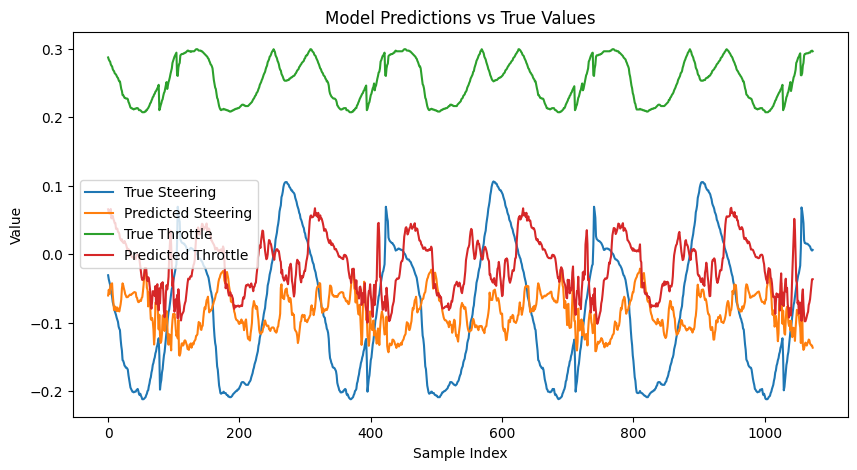

0.04405857956803897

In [14]:
evaluate_pruned_model(pruned_model, val_loader, nn.MSELoss(), device)  # recalibrate

Epoch [1/10], Train Loss: 0.0029
Epoch [1/10], Validation Loss: 0.0001
Epoch [2/10], Train Loss: 0.0001
Epoch [2/10], Validation Loss: 0.0001
Epoch [3/10], Train Loss: 0.0001
Epoch [3/10], Validation Loss: 0.0001
Epoch [4/10], Train Loss: 0.0001
Epoch [4/10], Validation Loss: 0.0001
Epoch [5/10], Train Loss: 0.0001
Epoch [5/10], Validation Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001
Epoch [6/10], Validation Loss: 0.0000
Epoch [7/10], Train Loss: 0.0001
Epoch [7/10], Validation Loss: 0.0001
Epoch [8/10], Train Loss: 0.0001
Epoch [8/10], Validation Loss: 0.0001
Epoch [9/10], Train Loss: 0.0001
Epoch [9/10], Validation Loss: 0.0001
Epoch [10/10], Train Loss: 0.0000
Epoch [10/10], Validation Loss: 0.0000


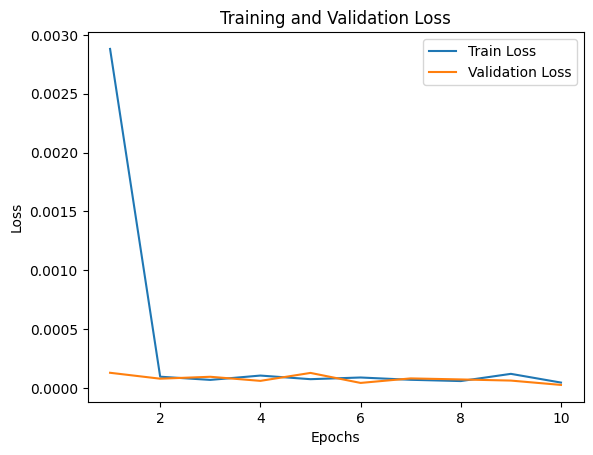

In [15]:
fine_tuned_model = fine_tune_pruned_model(pruned_model, train_loader, val_loader, num_epochs=10, device=device)

Validation Loss: 2.44238729143998e-05


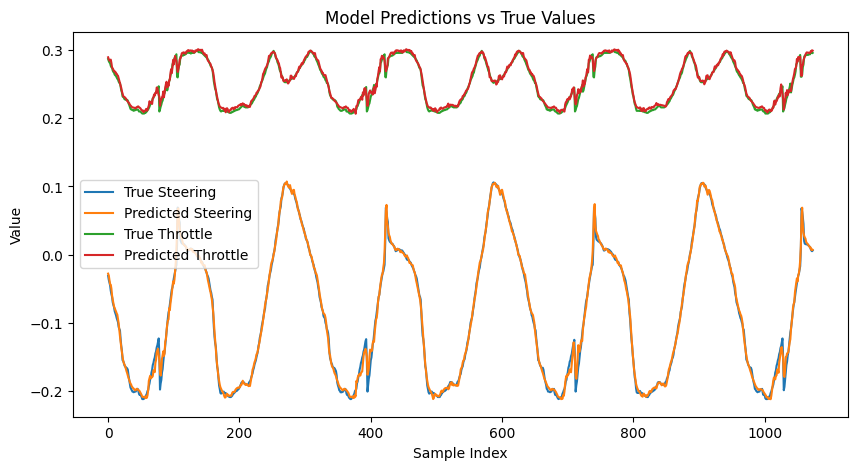

2.44238729143998e-05

In [16]:
evaluate_pruned_model(fine_tuned_model, val_loader, nn.MSELoss(), device)

In [17]:
torch.save(fine_tuned_model.state_dict(), '/content/drive/MyDrive/Dissertation/structured_pruned_model.pth')

Generalisation dies.

# 7: Knowledge Distillation

In [1]:
# student model is just the baseline but halved mostly
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeDistributedCNNStudent(nn.Module):
    def __init__(self):
        super(TimeDistributedCNNStudent, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=5, stride=2)  # smaller
        self.conv2 = nn.Conv2d(12, 18, kernel_size=5, stride=2)  # smaller
        self.conv3 = nn.Conv2d(18, 24, kernel_size=5, stride=2)  # smaller
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=1)  # smaller
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1)  # smaller
        self.flatten = nn.Flatten()

        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()
        self.fc = nn.Linear(self._to_linear, 64)  # adjusted to match output size

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 360, 640)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.convs(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        return x

class CNNLSTMModelStudent(nn.Module):
    def __init__(self, seq_length):
        super(CNNLSTMModelStudent, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = TimeDistributedCNNStudent()
        self.lstm_image = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)  # smaller
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=32, batch_first=True)  # smaller
        self.fc = nn.Linear(32 * 2, 2)  # adjusted

    def forward(self, x_image, x_lidar):
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.fc(x)
        return x

In [14]:
class DistillationLoss(nn.Module):  # combine MSE and KLDivision losses for combining hard and soft label learning
    def __init__(self, temperature=2.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion_ce = nn.MSELoss()
        self.criterion_kd = nn.KLDivLoss(reduction='batchmean')  # torch has this already

    def forward(self, student_output, teacher_output, target):  # combine them on the forward pass
        loss_ce = self.criterion_ce(student_output, target)
        loss_kd = self.criterion_kd(
            F.log_softmax(student_output / self.temperature, dim=1),
            F.softmax(teacher_output / self.temperature, dim=1)
        ) * (self.temperature ** 2)
        loss = self.alpha * loss_ce + (1.0 - self.alpha) * loss_kd
        return loss

In [15]:
def train_student_model(teacher_model, student_model, train_loader, val_loader, num_epochs=5, device='cuda'):
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
    criterion = DistillationLoss(temperature=2.0, alpha=0.5)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        student_model.train()
        running_loss = 0.0
        for batch in train_loader:
            x_image, x_lidar, target = batch
            x_image = x_image.to(device)
            x_lidar = x_lidar.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                teacher_output = teacher_model(x_image, x_lidar)
            student_output = student_model(x_image, x_lidar)
            loss = criterion(student_output, teacher_output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_image.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # validation
        student_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x_image, x_lidar, target = batch
                x_image = x_image.to(device)
                x_lidar = x_lidar.to(device)
                target = target.to(device)
                student_output = student_model(x_image, x_lidar)
                loss = F.mse_loss(student_output, target)
                val_loss += loss.item() * x_image.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss:.4f}')

    # plot the losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return student_model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/5, Loss: 0.0017
Validation Loss: 0.0002
Epoch 2/5, Loss: 0.0001
Validation Loss: 0.0001
Epoch 3/5, Loss: 0.0000
Validation Loss: 0.0001
Epoch 4/5, Loss: 0.0000
Validation Loss: 0.0001
Epoch 5/5, Loss: 0.0002
Validation Loss: 0.0001


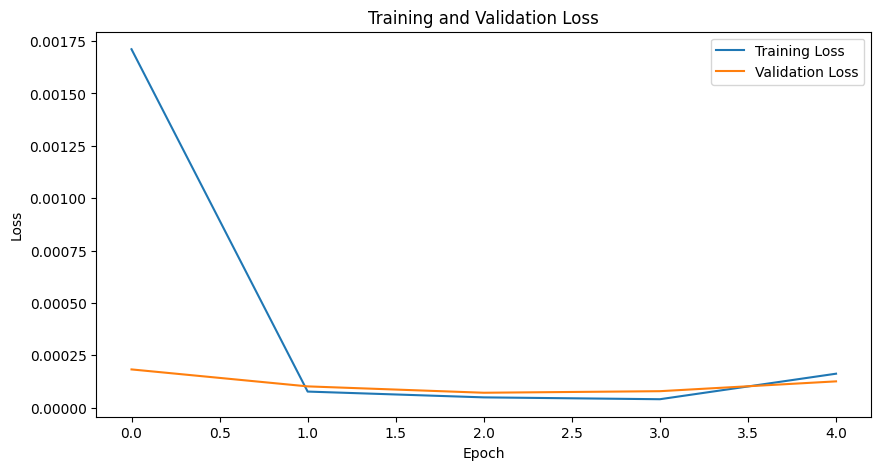

In [16]:
teacher_model = CNNLSTMModel(seq_length=10).to('cuda')
teacher_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/orpheus_torch.pth'))

student_model = CNNLSTMModelStudent(seq_length=10).to('cuda')
trained_student_model = train_student_model(teacher_model, student_model, train_loader, val_loader, num_epochs=5)

This extremely bad at generalising and looks like it's starting to overfit even.

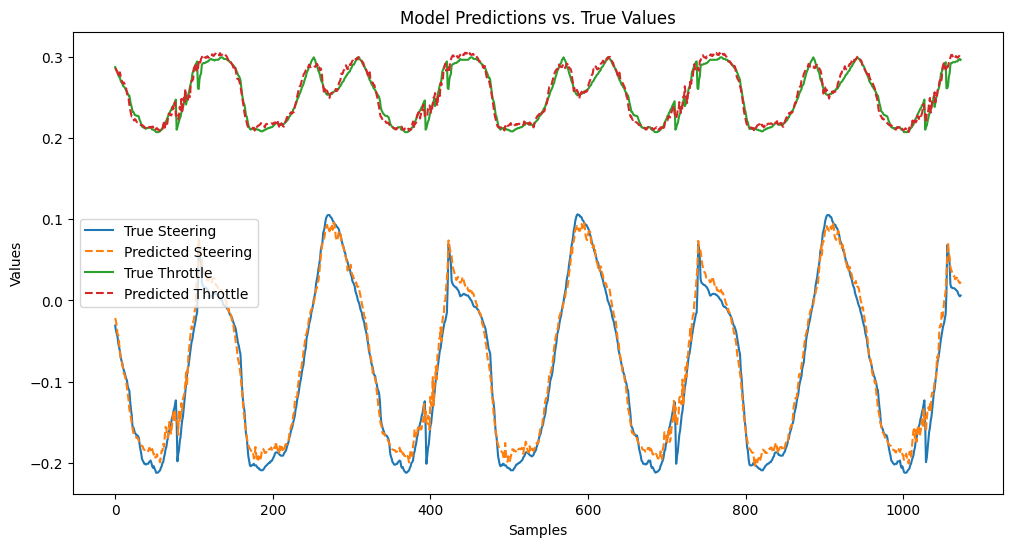

In [17]:
def plot_predictions(model, val_loader, device='cuda'):
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in val_loader:
            x_image, x_lidar, target = batch
            x_image = x_image.to(device)
            x_lidar = x_lidar.to(device)
            target = target.to(device)

            output = model(x_image, x_lidar)
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(all_targets[:, 0], label='True Steering')
    plt.plot(all_predictions[:, 0], label='Predicted Steering', linestyle='dashed')
    plt.plot(all_targets[:, 1], label='True Throttle')
    plt.plot(all_predictions[:, 1], label='Predicted Throttle', linestyle='dashed')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.title('Model Predictions vs. True Values')
    plt.legend()
    plt.show()

plot_predictions(trained_student_model, val_loader)

In [18]:
# save the trained student model
torch.save(student_model.state_dict(), '/content/drive/MyDrive/Dissertation/distilled_student_model.pth')
print("Student model saved")

Student model saved


In [19]:
def count_parameters(model):  # calc parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

teacher_model = CNNLSTMModel(seq_length=10).cuda()
teacher_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/orpheus_torch.pth'))

student_model = CNNLSTMModelStudent(seq_length=10).cuda()
student_model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/distilled_student_model.pth'))

print(f"Teacher model parameters: {count_parameters(teacher_model)}")
print(f"Student model parameters: {count_parameters(student_model)}")

# Check data types of parameters
teacher_param_dtypes = {name: param.dtype for name, param in teacher_model.named_parameters()}
student_param_dtypes = {name: param.dtype for name, param in student_model.named_parameters()}

print(f"Teacher model parameter data types: {teacher_param_dtypes}")
print(f"Student model parameter data types: {student_param_dtypes}")

Teacher model parameters: 18221434
Student model parameters: 5869956
Teacher model parameter data types: {'time_distributed_cnn.conv1.weight': torch.float32, 'time_distributed_cnn.conv1.bias': torch.float32, 'time_distributed_cnn.conv2.weight': torch.float32, 'time_distributed_cnn.conv2.bias': torch.float32, 'time_distributed_cnn.conv3.weight': torch.float32, 'time_distributed_cnn.conv3.bias': torch.float32, 'time_distributed_cnn.conv4.weight': torch.float32, 'time_distributed_cnn.conv4.bias': torch.float32, 'time_distributed_cnn.conv5.weight': torch.float32, 'time_distributed_cnn.conv5.bias': torch.float32, 'time_distributed_cnn.fc.weight': torch.float32, 'time_distributed_cnn.fc.bias': torch.float32, 'lstm_image.weight_ih_l0': torch.float32, 'lstm_image.weight_hh_l0': torch.float32, 'lstm_image.bias_ih_l0': torch.float32, 'lstm_image.bias_hh_l0': torch.float32, 'lstm_lidar.weight_ih_l0': torch.float32, 'lstm_lidar.weight_hh_l0': torch.float32, 'lstm_lidar.bias_ih_l0': torch.float32, 

# 8: Combination of Scaled Model with QAT and Pruning

Basically just test the scaled model with QAT, and check if pruning affects it at all.

In [1]:
# Mount my Drive to access the uploaded cam frames and sensor data CSV

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
data = np.load("/content/drive/MyDrive/Dissertation/X_train_smol.npz", allow_pickle=True)
X_train = pd.DataFrame({file: data[file] for file in data.files})
del data
print(X_train.head())

data = np.load("/content/drive/MyDrive/Dissertation/X_val_smol.npz", allow_pickle=True)
X_val = pd.DataFrame({file: data[file] for file in data.files})
del data
print(X_val.head())

data = np.load("/content/drive/MyDrive/Dissertation/y_train_smol.npz", allow_pickle=True)
y_train = pd.DataFrame({file: data[file] for file in data.files})
del data
print(y_train.head())

data = np.load("/content/drive/MyDrive/Dissertation/y_val_smol.npz", allow_pickle=True)
y_val = pd.DataFrame({file: data[file] for file in data.files})
del data
print(y_val.head())

                                        image_arrays  \
0  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
1  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
2  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
3  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
4  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   

                                        lidar_ranges  
0  [0.7463607, 0.7432726, 0.7402241, 0.7372144, 0...  
1  [0.7474717, 0.7444539, 0.7414744, 0.7385327, 0...  
2  [0.7515233, 0.7485677, 0.7456495, 0.742768, 0....  
3  [0.7594686, 0.7573279, 0.7552136, 0.7531253, 0...  
4  [0.7948893, 0.7926978, 0.7905333, 0.7883955, 0...  
                                        image_arrays  \
0  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
1  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
2  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
3  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1...   
4  [[[7, 18, 48], [7, 18, 48], [7, 18, 48], [7, 1... 

In [6]:
# ensure y_train and y_val are numpy arrays
y_train_steering = y_train['steering'].values
y_train_throttle = y_train['throttle'].values
y_val_steering = y_val['steering'].values
y_val_throttle = y_val['throttle'].values

# stack steering and throttle together
y_train = np.column_stack((y_train_steering, y_train_throttle))
y_val = np.column_stack((y_val_steering, y_val_throttle))

# convert the dframes to npy arrays
X_train_images = np.stack(X_train['image_arrays'].values)
X_train_lidars = np.stack(X_train['lidar_ranges'].values)
X_val_images = np.stack(X_val['image_arrays'].values)
X_val_lidars = np.stack(X_val['lidar_ranges'].values)

# verify shapes
print(f'Original X_train_images shape: {X_train_images.shape}')
print(f'Original X_train_lidars shape: {X_train_lidars.shape}')
print(f'Original X_val_images shape: {X_val_images.shape}')
print(f'Original X_val_lidars shape: {X_val_lidars.shape}')
print(f'Original y_train shape: {y_train.shape}')
print(f'Original y_val shape: {y_val.shape}')

Original X_train_images shape: (4330, 180, 320, 3)
Original X_train_lidars shape: (4330, 1081)
Original X_val_images shape: (1083, 180, 320, 3)
Original X_val_lidars shape: (1083, 1081)
Original y_train shape: (4330, 2)
Original y_val shape: (1083, 2)


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SteeringDataset(Dataset):
    def __init__(self, images, lidars, targets, seq_length):
        self.images = images
        self.lidars = lidars
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.images) - self.seq_length + 1

    def __getitem__(self, idx):
        image_seq = self.images[idx:idx + self.seq_length].astype(np.float32) / 255.0
        lidar_seq = self.lidars[idx:idx + self.seq_length].astype(np.float32) / 10.0
        target = self.targets[idx + self.seq_length - 1].astype(np.float32)  # predict target for the last time step

        image_seq_tensor = torch.tensor(image_seq).permute(0, 3, 1, 2)  # adjust dims to [seq_length, channels, height, width]
        lidar_seq_tensor = torch.tensor(lidar_seq)
        target_tensor = torch.tensor(target)

        return image_seq_tensor, lidar_seq_tensor, target_tensor

seq_length = 10

# create datasets
train_dataset = SteeringDataset(X_train_images, X_train_lidars, y_train, seq_length)
val_dataset = SteeringDataset(X_val_images, X_val_lidars, y_val, seq_length)

# create data loaders from datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# verify shapes
for image_seq, lidar_seq, target in train_loader:
    print(f'Image sequence shape: {image_seq.shape}')
    print(f'Lidar sequence shape: {lidar_seq.shape}')
    print(f'Target shape: {target.shape}')
    break

Image sequence shape: torch.Size([32, 10, 3, 180, 320])
Lidar sequence shape: torch.Size([32, 10, 1081])
Target shape: torch.Size([32, 2])


In [8]:
# SCALED MODEL

import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeDistributedCNN(nn.Module):
    def __init__(self):
        super(TimeDistributedCNN, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()

        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5
        )
        self._get_conv_output()
        self.fc = nn.Linear(self._to_linear, 100)
        self.dequant = torch.quantization.DeQuantStub()

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 180, 320)
            x = self.convs(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.quant(x)
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = x.view(batch_size, seq_length, -1)
        x = self.dequant(x)
        return x

class CNNLSTMModel(nn.Module):
    def __init__(self, seq_length):
        super(CNNLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.time_distributed_cnn = TimeDistributedCNN()
        self.lstm_image = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
        self.lstm_lidar = nn.LSTM(input_size=1081, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64 * 2, 2)  # Output 2 values: steering and throttle

    def forward(self, x_image, x_lidar):
        x_image = self.time_distributed_cnn(x_image)
        x_image, _ = self.lstm_image(x_image)
        x_lidar, _ = self.lstm_lidar(x_lidar)
        x = torch.cat((x_image[:, -1, :], x_lidar[:, -1, :]), dim=-1)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTMModel(seq_length=10).to(device)
print(model)

CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (quant): QuantStub()
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
      (2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
      (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (fc): Linear(in_features=31680, out_features=100, bias=True)
    (dequant): DeQuantStub()
  )
  (lstm_image): LSTM(100, 64, batch_first=True)
  (lstm_lidar): LSTM(1081, 64, batch_first=True)
  (fc): Linear(in_featu

In [9]:
torch.backends.quantized.engine = 'qnnpack'

qat_qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')

# apply the QAT configuration to the model
model.time_distributed_cnn.qconfig = qat_qconfig

# prepare the model for QAT
torch.quantization.prepare_qat(model.time_distributed_cnn, inplace=True)

TimeDistributedCNN(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=255, qscheme=torch.per_tensor_affine, reduce_range=False
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (conv1): Conv2d(
    3, 24, kernel_size=(5, 5), stride=(2, 2)
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_tensor_symmetric, reduce_range=False
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, m

In [10]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (image_seq, lidar_seq, target) in enumerate(train_loader):
            image_seq, lidar_seq, target = image_seq.to(device), lidar_seq.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(image_seq, lidar_seq)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.5f}')
                running_loss = 0.0


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda')
train(model, train_loader, criterion, optimizer, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:71.)
  return torch.fused_moving_avg_obs_fake_quant(


[Epoch 1, Batch 10] loss: 0.01947
[Epoch 1, Batch 20] loss: 0.00757
[Epoch 1, Batch 30] loss: 0.00296
[Epoch 1, Batch 40] loss: 0.00135
[Epoch 1, Batch 50] loss: 0.00087
[Epoch 1, Batch 60] loss: 0.00061
[Epoch 1, Batch 70] loss: 0.00036
[Epoch 1, Batch 80] loss: 0.00032
[Epoch 1, Batch 90] loss: 0.00030
[Epoch 1, Batch 100] loss: 0.00027
[Epoch 1, Batch 110] loss: 0.00047
[Epoch 1, Batch 120] loss: 0.00061
[Epoch 1, Batch 130] loss: 0.00060
[Epoch 2, Batch 10] loss: 0.00032
[Epoch 2, Batch 20] loss: 0.00030
[Epoch 2, Batch 30] loss: 0.00014
[Epoch 2, Batch 40] loss: 0.00010
[Epoch 2, Batch 50] loss: 0.00012
[Epoch 2, Batch 60] loss: 0.00011
[Epoch 2, Batch 70] loss: 0.00009
[Epoch 2, Batch 80] loss: 0.00008
[Epoch 2, Batch 90] loss: 0.00008
[Epoch 2, Batch 100] loss: 0.00008
[Epoch 2, Batch 110] loss: 0.00008
[Epoch 2, Batch 120] loss: 0.00009
[Epoch 2, Batch 130] loss: 0.00008
[Epoch 3, Batch 10] loss: 0.00010
[Epoch 3, Batch 20] loss: 0.00010
[Epoch 3, Batch 30] loss: 0.00009
[Epoch

In [11]:
# convert the model to a quantized version
model.eval()
model.cpu()
torch.ao.quantization.convert(model.time_distributed_cnn, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


TimeDistributedCNN(
  (quant): Quantize(scale=tensor([0.0039]), zero_point=tensor([0]), dtype=torch.quint8)
  (conv1): QuantizedConv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), scale=0.0122451763600111, zero_point=103)
  (conv2): QuantizedConv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), scale=0.012379264459013939, zero_point=108)
  (conv3): QuantizedConv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), scale=0.02686220221221447, zero_point=109)
  (conv4): QuantizedConv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02756989188492298, zero_point=101)
  (conv5): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.03478352352976799, zero_point=107)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convs): Sequential(
    (0): QuantizedConv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
    (1): QuantizedConv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
    (2): QuantizedConv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), scale=

In [12]:
# convolutional layers - same deal
def verify_conv_quantization(model):
    for name, module in model.named_modules():
      if hasattr(module, 'weight'):
        try:
            print(f'{name}: {module.weight().dtype}')
        except TypeError:
          pass

verify_conv_quantization(model)

# LSTM layers - same deal
def verify_lstm_quantization(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.LSTM):
            if hasattr(module, 'weight_ih_l0') and module.weight_ih_l0 is not None:
                print(f'{name}.weight_ih_l0: {module.weight_ih_l0.dtype}')
            if hasattr(module, 'weight_hh_l0') and module.weight_hh_l0 is not None:
                print(f'{name}.weight_hh_l0: {module.weight_hh_l0.dtype}')

verify_lstm_quantization(model)

time_distributed_cnn.conv1: torch.qint8
time_distributed_cnn.conv2: torch.qint8
time_distributed_cnn.conv3: torch.qint8
time_distributed_cnn.conv4: torch.qint8
time_distributed_cnn.conv5: torch.qint8
time_distributed_cnn.convs.0: torch.qint8
time_distributed_cnn.convs.1: torch.qint8
time_distributed_cnn.convs.2: torch.qint8
time_distributed_cnn.convs.3: torch.qint8
time_distributed_cnn.convs.4: torch.qint8
time_distributed_cnn.fc: torch.qint8
lstm_image.weight_ih_l0: torch.float32
lstm_image.weight_hh_l0: torch.float32
lstm_lidar.weight_ih_l0: torch.float32
lstm_lidar.weight_hh_l0: torch.float32


In [15]:
print("Saving the model")
torch.save(model.state_dict(), f"/content/drive/MyDrive/Dissertation/orpheus_master_qat.pth")
print("Model saved")

Saving the model
Model saved


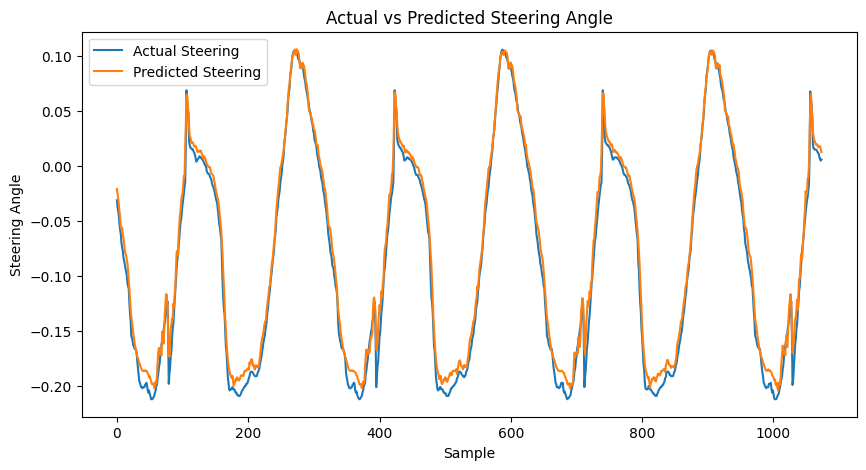

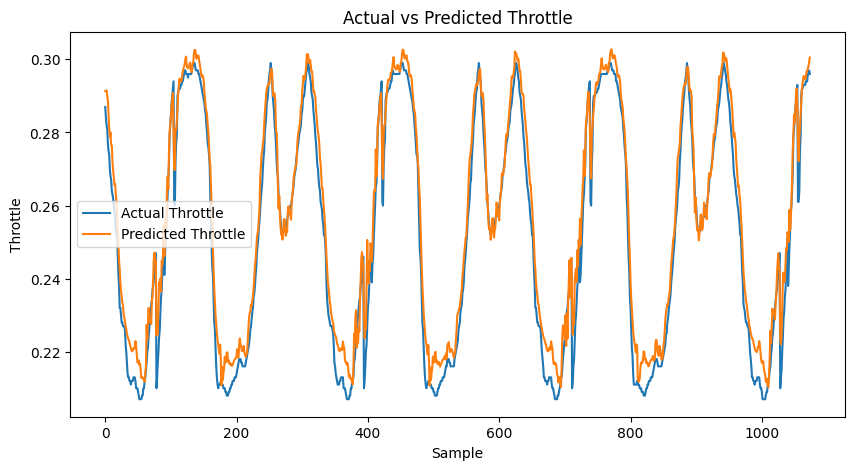

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_validation_accuracy(model, val_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images_seq, lidars_seq, targets in val_loader:
            images_seq, lidars_seq = images_seq.to(device), lidars_seq.to(device)
            outputs = model(images_seq, lidars_seq)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # plot Steering Angle
    plt.figure(figsize=(10, 5))
    plt.plot(all_targets[:, 0], label='Actual Steering')
    plt.plot(all_preds[:, 0], label='Predicted Steering')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle')
    plt.legend()
    plt.title('Actual vs Predicted Steering Angle')
    plt.show()

    # plot Throttle
    plt.figure(figsize=(10, 5))
    plt.plot(all_targets[:, 1], label='Actual Throttle')
    plt.plot(all_preds[:, 1], label='Predicted Throttle')
    plt.xlabel('Sample')
    plt.ylabel('Throttle')
    plt.legend()
    plt.title('Actual vs Predicted Throttle')
    plt.show()

device = torch.device('cpu')
plot_validation_accuracy(model, val_loader, device)

Applied pruning at epoch 0
Epoch 1/10, Train Loss: 0.0001, Validation Loss: 0.0000
Applied pruning at epoch 1
Epoch 2/10, Train Loss: 0.0001, Validation Loss: 0.0001
Applied pruning at epoch 2
Epoch 3/10, Train Loss: 0.0000, Validation Loss: 0.0001
Applied pruning at epoch 3
Epoch 4/10, Train Loss: 0.0001, Validation Loss: 0.0001
Applied pruning at epoch 4
Epoch 5/10, Train Loss: 0.0001, Validation Loss: 0.0000
Applied pruning at epoch 5
Epoch 6/10, Train Loss: 0.0000, Validation Loss: 0.0001
Applied pruning at epoch 6
Epoch 7/10, Train Loss: 0.0000, Validation Loss: 0.0000
Applied pruning at epoch 7
Epoch 8/10, Train Loss: 0.0001, Validation Loss: 0.0003
Applied pruning at epoch 8
Epoch 9/10, Train Loss: 0.0001, Validation Loss: 0.0000
Applied pruning at epoch 9
Epoch 10/10, Train Loss: 0.0000, Validation Loss: 0.0000


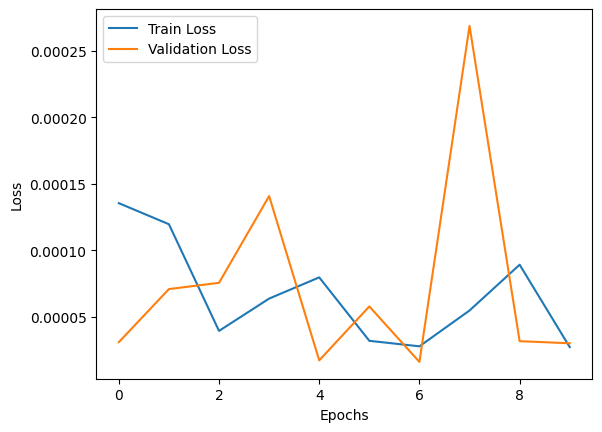

In [17]:
# unstructured Pruning on the model.
import torch.nn.utils.prune as prune

def apply_pruning(model, amount, architecture):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            print(f"Pruning {module}")
            prune.remove(module, 'weight')  # perma remove weight masks

# train with unstructured pruned
def train_with_pruning(model, train_loader, val_loader, num_epochs, device='cpu', pruning_amount=0.2, prune_every_n_epochs=1):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []
    architecture = {}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs_image, inputs_lidar, labels = data
            inputs_image, inputs_lidar, labels = inputs_image.to(device), inputs_lidar.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs_image, inputs_lidar)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # apply pruning
        if epoch % prune_every_n_epochs == 0:
            apply_pruning(model, pruning_amount, architecture)
            print(f'Applied pruning at epoch {epoch}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs_image, inputs_lidar, labels = data
                inputs_image, inputs_lidar, labels = inputs_image.to(device), inputs_lidar.to(device), labels.to(device)

                outputs = model(inputs_image, inputs_lidar)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # plotting the training and validation loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, architecture

pruned_model, architecture = train_with_pruning(model, train_loader, val_loader, num_epochs=10, pruning_amount=0.5, prune_every_n_epochs=1)

Unstructured Pruning deletes the accuracy, let alone everything else.

In [18]:
!pip install torch-pruning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [19]:
import torch_pruning as tp

def prune_model(model, example_inputs, amount=0.5):  # same pruning ratio as before
    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            num_prune = int(module.out_channels * amount)
            if num_prune == 0:
                continue
            pruning_idxs = list(range(num_prune))
            group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=pruning_idxs)

            if DG.check_pruning_group(group):
                group.prune()
                print(f"Pruned {num_prune} channels from {name}")

    model.zero_grad()
    return model


device = torch.device('cpu')
model = CNNLSTMModel(seq_length=10).to(device)

example_image_input = torch.randn(1, 10, 3, 180, 320).to(device)
example_lidar_input = torch.randn(1, 10, 1081).to(device)

pruned_model = prune_model(pruned_model, (example_image_input, example_lidar_input))
print(pruned_model)

CNNLSTMModel(
  (time_distributed_cnn): TimeDistributedCNN(
    (quant): Quantize(scale=tensor([0.0039]), zero_point=tensor([0]), dtype=torch.quint8)
    (conv1): QuantizedConv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), scale=0.0122451763600111, zero_point=103)
    (conv2): QuantizedConv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), scale=0.012379264459013939, zero_point=108)
    (conv3): QuantizedConv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), scale=0.02686220221221447, zero_point=109)
    (conv4): QuantizedConv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02756989188492298, zero_point=101)
    (conv5): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.03478352352976799, zero_point=107)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (convs): Sequential(
      (0): QuantizedConv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
      (1): QuantizedConv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), scale=1.0, zero_point=0)
      (2): Qua

Epoch [1/10], Train Loss: 0.0001
Epoch [1/10], Validation Loss: 0.0000
Epoch [2/10], Train Loss: 0.0000
Epoch [2/10], Validation Loss: 0.0001
Epoch [3/10], Train Loss: 0.0001
Epoch [3/10], Validation Loss: 0.0000
Epoch [4/10], Train Loss: 0.0001
Epoch [4/10], Validation Loss: 0.0001
Epoch [5/10], Train Loss: 0.0000
Epoch [5/10], Validation Loss: 0.0000
Epoch [6/10], Train Loss: 0.0000
Epoch [6/10], Validation Loss: 0.0000
Epoch [7/10], Train Loss: 0.0001
Epoch [7/10], Validation Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000
Epoch [8/10], Validation Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000
Epoch [9/10], Validation Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000
Epoch [10/10], Validation Loss: 0.0000


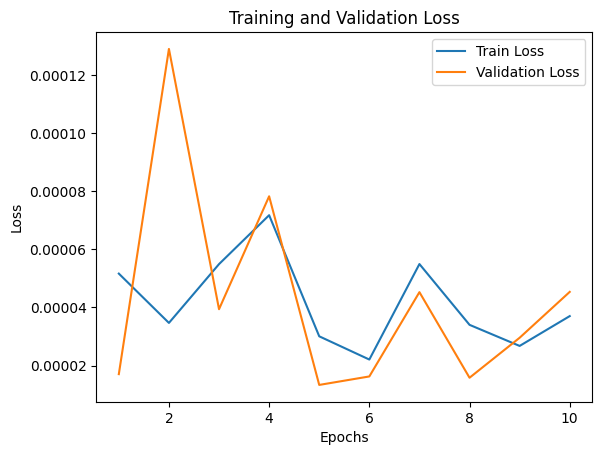

In [21]:
def fine_tune_pruned_model(pruned_model, train_loader, val_loader, num_epochs, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(pruned_model.parameters(), lr=0.001)

    pruned_model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        pruned_model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            x_image, x_lidar, targets = batch
            x_image = x_image.to(device)
            x_lidar = x_lidar.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = pruned_model(x_image, x_lidar)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

        pruned_model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x_image, x_lidar, targets = batch
                x_image = x_image.to(device)
                x_lidar = x_lidar.to(device)
                targets = targets.to(device)

                outputs = pruned_model(x_image, x_lidar)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


    # plot training and validation loss
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return pruned_model

fine_tuned_model = fine_tune_pruned_model(pruned_model, train_loader, val_loader, num_epochs=10)

Same as Unstructured Pruning, this ruins accuracy and the uptick suggests overfitting.

In [22]:
torch.save(fine_tuned_model.state_dict(), f"/content/drive/MyDrive/Dissertation/orpheus_master_qat_pruned.pth")

That concludes that QAT and Image Scaling reach near ideal and adding in pruning worsens the formula. Perhaps Distillation could work on non sequential data or with more varied data?